In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !tar -xvf /content/drive/MyDrive/11632Capstone/lpd_5_cleansed.tar.gz
# !tar -xvf /content/drive/MyDrive/11632Capstone/lpd_5_matched.tar.gz
!tar -xvf /content/drive/MyDrive/11632Capstone/final_data_0907.tar.gz
!unzip /content/drive/MyDrive/11632Capstone/Archive.zip

In [4]:
! pip install miditoolkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 3.3 MB/s 


In [1]:
import glob
import os
import json
import csv
import random
import utils
import numpy as np
import pandas as pd
import itertools as it

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import re

## Reading Data

In [2]:
MATCHED_PATH = "lpd_5/lpd_5_matched/"
CLEANED_PATH = "lpd_5/lpd_5_cleansed/"
MUMU_AMAZON_PATH = "MuMu_dataset/amazon_reviews_MuMu.json"
MUMU_MULTI_PATH = "MuMu_dataset/MuMu_dataset_multi-label.csv"
MUMU_SINGLE_PATH = "MuMu_dataset/MuMu_dataset_single-label.csv"
REMI_PATH = "remi/"

matched_file_paths = []
for x in os.walk(MATCHED_PATH):
    for y in glob.glob(os.path.join(x[0], '*.npz')):
        matched_file_paths.append(y)

cleaned_file_paths = []
for x in os.walk(CLEANED_PATH):
    for y in glob.glob(os.path.join(x[0], '*.npz')):
        cleaned_file_paths.append(y)

# broken_remi = ['TRRPLUG128F427E59C',
#  'TRFINAP128F93269EF',
#  'TRMSNKX128F9355DDA',
#  'TRDRFXO128F14918D8',
#  'TRVMEZF128F92C82F6',
#  'TRKIZWL128EF342C5A',
#  'TRLWVSP128F423C35A']
remi_file_paths = []
for x in os.walk(REMI_PATH):
    for y in glob.glob(os.path.join(x[0], '*.npz')):
        remi_file_paths.append(y.split('/')[1])

In [3]:
# total number of songs
print(len(matched_file_paths), len(cleaned_file_paths), len(remi_file_paths))

0 0 34241


In [3]:
mumu_multi_df = pd.read_csv(MUMU_MULTI_PATH)
mumu_single_df = pd.read_csv(MUMU_SINGLE_PATH)
mumu_amazon_df = pd.read_json(MUMU_AMAZON_PATH, lines=True)

## Text Label Exploration

In [ ]:
#explore genres
total = 0
for i in range(len(mumu_multi_df)):
  total += len(mumu_multi_df['genres'][i])
print(total / len(mumu_multi_df))
for i in range(10):
  print(mumu_multi_df['genres'][i])

Vocal Jazz,Jazz,Traditional Vocal Pop,Pop,Modern Postbebop,Broadway & Vocalists,Vocal Pop,Bebop
Vocal Jazz,Jazz,Traditional Vocal Pop,Pop,Modern Postbebop,Broadway & Vocalists,Vocal Pop,Bebop
Vocal Jazz,Jazz,Traditional Vocal Pop,Pop,Modern Postbebop,Broadway & Vocalists,Vocal Pop,Bebop
Vocal Jazz,Jazz,Traditional Vocal Pop,Pop,Modern Postbebop,Broadway & Vocalists,Vocal Pop,Bebop
Vocal Jazz,Jazz,Traditional Vocal Pop,Pop,Modern Postbebop,Broadway & Vocalists,Vocal Pop,Bebop
Oldies,Pop,Rock
Oldies,Pop,Rock
Pop Rap,Jazz,Vocal Jazz,Pop,Easy Listening,Rap & Hip-Hop,Rock,Vocal Pop
Pop Rap,Jazz,Vocal Jazz,Pop,Easy Listening,Rap & Hip-Hop,Rock,Vocal Pop
Pop Rap,Jazz,Vocal Jazz,Pop,Easy Listening,Rap & Hip-Hop,Rock,Vocal Pop


In [ ]:
#explore text labels
minn = 100
maxx = 0
avgg = 0
for i in range(len(mumu_amazon_df)):
  minn = min(minn, len(mumu_amazon_df['reviewText'][i]))
  maxx = max(maxx, len(mumu_amazon_df['reviewText'][i]))
  avgg += len(mumu_amazon_df['reviewText'][i])
print(minn, maxx, avgg/len(mumu_amazon_df))
print(mumu_amazon_df['reviewText'].apply(len).median())
for i in range(10):
  print(mumu_amazon_df['reviewText'][i])
# mumu_amazon_df['reviewText'][0]
with open(r'amazon_text_label_sample.txt', 'w') as fp:
    fp.write('\n'.join(mumu_amazon_df['reviewText'][:100]))

0 28888 728.2627736084704
463.0
Earth and Sky Dancing Music, intelligent on so many levels. Co-writers Costa/ St.John Ramirez deliver a blend of Indigenous Soul Music with R&B and Afro Latin Rhythms that is smooth, fun & deep. And with Justo Almario on horns - can you handle it? Oh Yea!
I bought this based on the snippets that they give you here on Amazon.  The actual C.D. is much better than even the previews give you.  It gives you energy, makes you want to get up and dance and twirl around with your hands over your head.  It's also great to listen in the car, it makes any trip go by very quickly.  My advice would be to buy it, it's one of the best Kirtan C.D.'s I've heard yet.  The first C.D. is very fast paced and the second is more mellow, more open to interpretation.
I really love Jai's voice, it's soothing and transcendent. A great album for anyone who loves kirtan.Very informative  too.
This is ok but it's not very relaxing... I would classify this music as a bollywood soundtra

## Generate List of recording with MSD to tranfrom to Remi

In [ ]:
#list of MSD and recording ids of the piano roll dataset to transfer to Remi
cleaned_MSD_id_list = []
uncleaned_MSD_id_list = []
recording_mbid_list = []
for i in range(len(cleaned_file_paths)):
    curr_path = cleaned_file_paths[i]
    curr_MSD_id = curr_path.split('/')[-2]
    cleaned_MSD_id_list.append(curr_MSD_id)
for i in range(len(matched_file_paths)):
    curr_path = matched_file_paths[i]
    curr_MSD_id = curr_path.split('/')[-2]
    uncleaned_MSD_id_list.append(curr_MSD_id)
    recording_mbid_list.append(curr_path.split('/')[-1].split('.')[0])
unique_uncleaned_MSD_id_list = list(set(uncleaned_MSD_id_list))

In [ ]:
#match msd with Mumu
multi_list = set(unique_uncleaned_MSD_id_list) & set(mumu_multi_df['MSD_track_id'])
single_list = set(unique_uncleaned_MSD_id_list) & set(mumu_single_df['MSD_track_id'])
print(len(multi_list), len(single_list))
print(len(set(multi_list | single_list)))
matched_msd = set(multi_list | single_list)

#write to file
with open(r'matched_msdID.txt', 'w') as fp:
    fp.write('\n'.join(matched_msd))


3132 427
3328


## Match Remi to Amazon Review

In [4]:
# create label list of all amazon review labels
label_list = mumu_amazon_df['reviewText'].explode('reviewText').values


In [27]:
remi_file_paths.sort()

pos_tuple_list = []
neg_tuple_list = []
min_remi_length = 1818
max_remi_length = 0
avg_remi_length = 0
idx = 0

# curr_MSD_id = remi_file_paths[0].split('.')[0].split('_')[0]

while idx < len(remi_file_paths):
# while idx < 1000:
    curr_MSD_id = remi_file_paths[idx].split('.')[0].split('_')[0]
    curr_amazon_id = mumu_multi_df.loc[mumu_multi_df['MSD_track_id'] == curr_MSD_id]
    if len(curr_amazon_id) == 0:
        curr_amazon_id = mumu_single_df.loc[mumu_single_df['MSD_track_id'] == curr_MSD_id]
    curr_review = mumu_amazon_df.loc[mumu_amazon_df['amazon_id'] == curr_amazon_id['amazon_id'].values[0]]['reviewText'].values
    # if not curr_review.any():
    #   print(curr_MSD_id)
    # curr_data = []
    while idx < len(remi_file_paths) and remi_file_paths[idx].split('.')[0].split('_')[0] == curr_MSD_id:
        for review in curr_review:
            if review == "":
                continue
            pos_tuple_list.append([remi_file_paths[idx].split('.')[0], review])
            neg_review = review
            while neg_review in curr_review:
                neg_review = random.choice(label_list)
            neg_tuple_list.append([remi_file_paths[idx].split('.')[0], neg_review])
        # curr_data.append(data_nparr.tolist())
        idx += 1
    
    # combinations = it.product(curr_data, curr_review)
    # comb_array = np.array(np.meshgrid(curr_data, curr_review)).T.reshape(-1, 2)
    # pos_tuple_list.extend(combinations)


In [ ]:
# pd.DataFrame(neg_tuple_list)[1][pd.DataFrame(neg_tuple_list)[1].isna()]
# pos = np.sort(np.array(pos_tuple_list)[:, 0])
# np.array_equal(np.sort(np.array(pos_tuple_list)[:, 0]), np.sort(np.array(neg_tuple_list)[:, 0]))
# (np.array(pos_tuple_list)[:, 0]==np.array(neg_tuple_list)[:, 0]).all()

In [ ]:
len(pos_tuple_list)

684004

## Match Remi to Genre

In [6]:
multi_genre = set(mumu_multi_df['genres'].apply(lambda x: x.split(',')).explode())
sing_genre = set(mumu_single_df['genres'].apply(lambda x: x.split(',')).explode())
genres_list = set(multi_genre.union(sing_genre))

In [7]:
pos_genre_list = []
neg_genre_list = []
idx = 0


while idx < len(remi_file_paths):
# while idx < 40:
    curr_MSD_id = remi_file_paths[idx].split('.')[0].split('_')[0]
    curr_amazon_id = mumu_multi_df.loc[mumu_multi_df['MSD_track_id'] == curr_MSD_id]
    if len(curr_amazon_id) == 0:
        curr_amazon_id = mumu_single_df.loc[mumu_single_df['MSD_track_id'] == curr_MSD_id]
    curr_genre = curr_amazon_id['genres'].values[0]
    num_genre = len(set(curr_genre.split(',')))
    genre_set = genres_list - set(curr_genre.split(','))
    

    while idx < len(remi_file_paths) and remi_file_paths[idx].split('.')[0].split('_')[0] == curr_MSD_id:
        pos_genre_list.append([remi_file_paths[idx].split('.')[0], curr_genre])
        neg_genre = ",".join(random.sample(genre_set, num_genre))
        neg_genre_list.append([remi_file_paths[idx].split('.')[0], neg_genre])
        idx += 1
  

In [55]:
len(neg_genre_list)
# type(neg_genre)
neg_genre_list[368:370]

[['TRAGQOE128F92DD8E6_9784fadf94bf69fd07ba467042619fc4_3',
  'Death Metal,Belgium,Praise & Worship'],
 ['TRAGQOE128F92DD8E6_9784fadf94bf69fd07ba467042619fc4_4',
  'Rap Rock,Trance,Country & Bluegrass']]

In [60]:
np.array_equal(np.sort(np.array(pos_genre_list)[:, 0]), np.sort(np.array(neg_genre_list)[:, 0]))

True

## Previous midi and remi code (not used)

In [ ]:
label_list = []
tuple_list = []
DATA_LENGTH = 20000
NUM_FILE = 100
min_remi_length = 1818
max_remi_length = 0
avg_remi_length = 0

CLEANED = False

idx = 0
while len(tuple_list) < len(remi_file_paths):
#     MSD_ids = cleaned_MSD_id_list if CLEANED else unique_uncleaned_MSD_id_list
#     curr_path = cleaned_file_paths[idx] if CLEANED else matched_file_paths[idx]
#     curr_MSD_id = curr_path.split('/')[-2]
    curr_path = remi_file_paths[idx]
    curr_MSD_id = curr_path.split('.')[0].split('/')[-1]
    idx += 1
    
    curr_amazon_id = mumu_multi_df.loc[mumu_multi_df['MSD_track_id'] == curr_MSD_id]
    if len(curr_amazon_id) == 0:
        curr_amazon_id = mumu_single_df.loc[mumu_single_df['MSD_track_id'] == curr_MSD_id]
        # if len(curr_amazon_id) == 0:
        #     continue
        
# For Midi            
    # npz = np.load(curr_path)
    # df= pd.DataFrame.from_dict({item: npz[item] for item in npz.files}, orient='index').T
#     data_nparr = df[['pianoroll_0_csc_data', 'pianoroll_1_csc_data', 'pianoroll_2_csc_data', 'pianoroll_3_csc_data', 'pianoroll_4_csc_data']].fillna(0).to_numpy()
#     if data_nparr.shape[0] > DATA_LENGTH:
#         data_nparr = data_nparr[:DATA_LENGTH + 1]
#     elif data_nparr.shape[0] < DATA_LENGTH:
#         np.pad(data_nparr, (0, DATA_LENGTH - data_nparr.shape[0]), 'constant', constant_values=(0, 0))

# For Rmi
    # print(curr_path)
    npz = np.load(curr_path, allow_pickle=True)
    data_nparr=npz['arr_0']
    min_remi_length = min(min_remi_length, len(data_nparr))
    max_remi_length = max(max_remi_length, len(data_nparr))
    avg_remi_length += len(data_nparr)
    # print(curr_amazon_id)
    curr_review = mumu_amazon_df.loc[mumu_amazon_df['amazon_id'] == curr_amazon_id['amazon_id'].values[0]]['reviewText']
    curr_tuple = [data_nparr.tolist(), curr_review.values[0]]
    tuple_list.append(curr_tuple)
    label_list.append(curr_review.values[0])

avg_remi_length /= len(remi_file_paths)

In [ ]:
print(min_remi_length, max_remi_length, avg_remi_length)

4 4 4.0


In [ ]:
neg_tuple_list = []
for tuples in tuple_list:
    neg_label = tuples[1]
    while neg_label == tuples[1]:
        neg_label = random.choice(label_list)
    neg_tuple = [tuples[0], neg_label]
    neg_tuple_list.append(neg_tuple)

In [ ]:
tuple_test = []
for i in range(5):
  sample_data = tuple_list[i][0][0][:4]
  sample_data.append("...")
  sample_data.append(tuple_list[i][0][1][:4])
  sample_data.append("...")
  sample_data.append(tuple_list[i][0][2][:4])
  sample_data.append("...")
  sample_label = tuple_list[i][1][:80]
  sample_label += "..."
  tuple_test.append((sample_data, sample_label))
df_test = pd.DataFrame(tuple_test, columns=['data', 'label'])
df_test

,data,label
0,"[0, 217, 471, 609, ..., [{'name': 'Bar', 'valu...",The Truman Show should have been 1998's Best P...
1,"[0, 36, 71, 115, ..., [{'name': 'Bar', 'value'...",This second (and unfortunately last) effort fr...
2,"[0, 20, 58, 224, ..., [{'name': 'Bar', 'value'...","Dynamic and inventive, Moore relies on more th..."
3,"[0, 136, 329, 502, ..., [{'name': 'Bar', 'valu...",With all of the comments about how this album ...
4,"[0, 28, 48, 53, ..., [{'name': 'Bar', 'value':...",Buy this CD 'cuz baby it just burns!Do you rea...


In [ ]:
min_token_length = 10000
max_token_length = 0
avg_token_length = 0
for label in label_list:
  token_list = label.split(' ')
  min_token_length = min(min_token_length, len(token_list))
  max_token_length = max(max_token_length, len(token_list))
  avg_token_length += len(token_list)
avg_token_length /= len(label_list)

In [ ]:
print(min_token_length, max_token_length, avg_token_length)

1 1774 120.20765262252795


In [ ]:
#mintime: 1824
#maxtime: 166926
#avgtime of first 100: 31551.36

#number of cleaned pianoroll tracks: 21425
#cleaned tracks matched to unique labels: 2504 / 1916 / 1701 / 1816 /2333
#all matching labels of cleaned tracks: 39776 / 40172

#number of uncleaned pianoroll recordings: 115160
#unique uncleaned tracks matched to unique labels: 3559 / 3328
#all matching labels of unique uncleaned tracks: 76861
#all uncleaned recordings matched to repetative lablels: 11697

#size of entire mumudataset: 956292
# There may be multiple reviews to the same MSD track!!!

#count pianoroll matched to amazon review
count = 0
count_review = 0
matchable_ids = []
for idd in cleaned_MSD_id_list:
    curr_amazon_id = mumu_single_df.loc[mumu_single_df['MSD_track_id'] == idd]
    if len(curr_amazon_id) == 0:
        curr_amazon_id = mumu_multi_df.loc[mumu_multi_df['MSD_track_id'] == idd]
        if len(curr_amazon_id) == 0:
            continue
    matchable_ids.append(idd)
    curr_review = mumu_amazon_df.loc[mumu_amazon_df['amazon_id'] == curr_amazon_id['amazon_id'].values[0]]['reviewText']
    count += 1
    count_review += len(curr_review.values)

## Shuffle to Train Val Test

In [46]:
# total number of unique songs
all_song = set(map(lambda x: x.split('_')[0], remi_file_paths))
# 8 + 1 +1 = 2433 + 304 + 304
train_song = random.sample(all_song, 2433)
val_song = random.sample(all_song - set(train_song), 304)
test_song = random.sample(all_song - set(train_song) - set(val_song), 304)

In [47]:
pos_full_list = pos_tuple_list + pos_genre_list
neg_full_list = neg_tuple_list + neg_genre_list
pos_full_list.sort()
neg_full_list.sort()

pos_train_list = []
pos_val_list = []
pos_test_list = []
neg_train_list = []
neg_val_list = []
neg_test_list = []

# random.shuffle(pos_full_list)
# random.shuffle(neg_full_list)
for idx in range(len(pos_full_list)):
    if pos_full_list[idx][0].split('_')[0] in train_song:
        pos_train_list.append(pos_full_list[idx])
        neg_train_list.append(neg_full_list[idx])
    elif pos_full_list[idx][0].split('_')[0] in val_song:
        pos_val_list.append(pos_full_list[idx])
        neg_val_list.append(neg_full_list[idx])
    else:
        pos_test_list.append(pos_full_list[idx])
        neg_test_list.append(neg_full_list[idx])

# train: 574998
# val: 80007
# test: 63240
# total: 718245

In [48]:
print(len(pos_full_list))
print(len(pos_train_list))
print(len(pos_val_list))
print(len(pos_test_list))

print(len(neg_full_list))
print(len(neg_train_list))
print(len(neg_val_list))
print(len(neg_test_list))

718227
582663
59465
76099
718227
582663
59465
76099


## Saving to File

In [52]:
POS_TUPLE_PATH = "/content/drive/MyDrive/11632Capstone/pos_tuples_train.csv"
NEG_TUPLE_PATH = "/content/drive/MyDrive/11632Capstone/neg_tuples_train.csv"
fields = ['file_name', 'label'] 
with open(POS_TUPLE_PATH, 'w') as f:
    write = csv.writer(f)
    write.writerow(fields)
    write.writerows(pos_train_list)
with open(NEG_TUPLE_PATH, 'w') as f:
    write = csv.writer(f)
    write.writerow(fields)
    write.writerows(neg_train_list)

In [ ]:
textfile = open("matchable_ids.txt", "w")
for matchable_id in matchable_ids:
    textfile.write(matchable_id + "\n")
textfile.close()

In [ ]:
print(len(matchable_ids))

2333


## Genre Distribution Exploration

In [ ]:
pos_genre_df = pd.read_csv('/content/drive/MyDrive/11632Capstone/pos_tuples_full.csv')  
neg_genre_df = pd.read_csv('/content/drive/MyDrive/11632Capstone/neg_tuples_full.csv')  


In [ ]:
music_list = pos_genre_df['file_name'].unique()
all_pos_genre = []
idx = 0
while idx < len(music_list):
# while idx < 40:
    curr_MSD_id = music_list[idx].split('.')[0].split('_')[0]
    curr_amazon_id = mumu_multi_df.loc[mumu_multi_df['MSD_track_id'] == curr_MSD_id]
    if len(curr_amazon_id) == 0:
        curr_amazon_id = mumu_single_df.loc[mumu_single_df['MSD_track_id'] == curr_MSD_id]
    curr_genre = curr_amazon_id['genres'].values[0]
    # num_genre = len(set(curr_genre.split(',')))
    # genre_set = genres_list - set(curr_genre.split(','))
    

    while idx < len(music_list) and music_list[idx].split('.')[0].split('_')[0] == curr_MSD_id:
        all_pos_genre.append(curr_genre)
        # neg_genre = ",".join(random.sample(genre_set, num_genre))
        # neg_genre_list.append([music_list[idx].split('.')[0], neg_genre])
        idx += 1

In [ ]:
music_list = pd.DataFrame(pos_genre_df['file_name'].unique(), columns = ['file_name'])
def get_genre(file_name):
    # print(file_name)
    curr_MSD_id = file_name.split('.')[0].split('_')[0]
    curr_amazon_id = mumu_multi_df.loc[mumu_multi_df['MSD_track_id'] == curr_MSD_id]
    if len(curr_amazon_id) == 0:
        curr_amazon_id = mumu_single_df.loc[mumu_single_df['MSD_track_id'] == curr_MSD_id]
    return curr_amazon_id['genres'].values[0]
music_list['genre'] = music_list['file_name'].apply(lambda x: get_genre(x))
# len(music_list)

In [ ]:
len(all_pos_genre)

34241

In [ ]:
music_list['genre'][36]
music_list.genre.apply(len).describe()
len(music_list[music_list['genre'].str.len()<65])

22098

In [ ]:
len(neg_genre_df[neg_genre_df['label'].str.len()<65])
filtered_neg_df = neg_genre_df[neg_genre_df['label'].str.len()<65]

24728

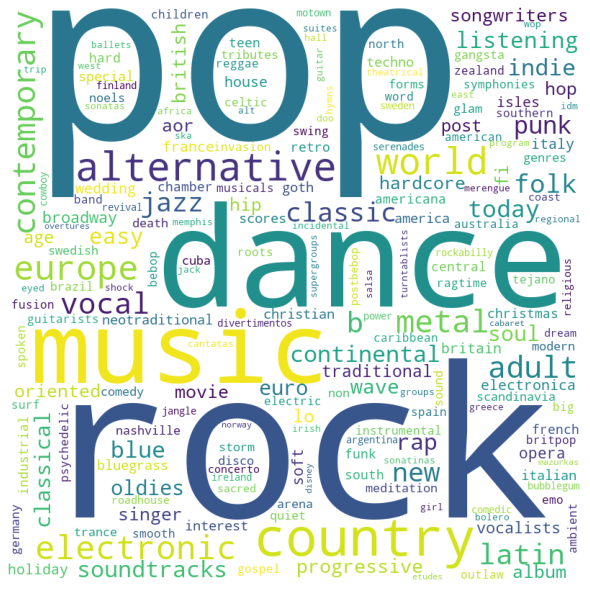

In [ ]:
# all positive genre labels
comment_words = ''
stopwords = set(STOPWORDS)
 
for val in music_list['genre']:
    tokens = re.split(' |,', val)
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                collocations = False,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

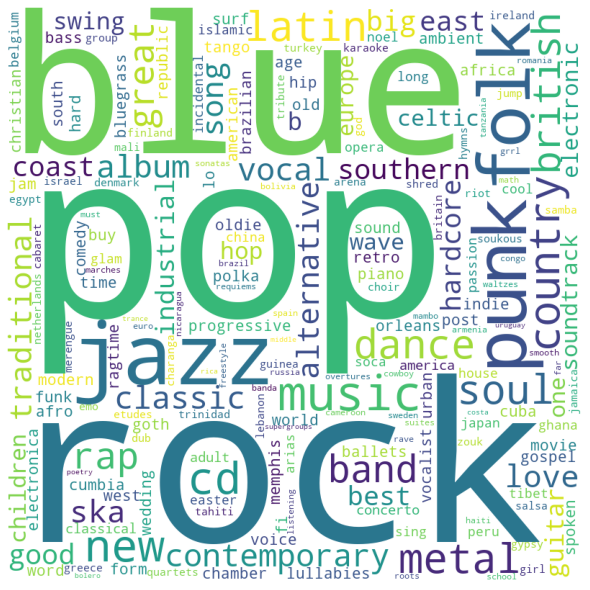

In [ ]:
# estimate of all negative genre labels
comment_words = ''
stopwords = set(STOPWORDS)
 
for val in filtered_neg_df['label']:
# for idx in range(40):
    # val = music_list['genre'][idx]
    # val = str(val)
    # tokens = val.split()
    tokens = re.split(' |,', val)
    # print(tokens)
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                collocations = False,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [ ]:
neg_genre_df['label'].isnull().sum()

29

In [ ]:
list(pos_genre_df[neg_genre_df['label'].isnull()]['file_name'])

['TRAGQOE128F92DD8E6_1c151c0fc1b71592f63d2c180f6b4b6d_4',
 'TRAOTSK128F1452CB0_9fd415b4afebbb23eabf377151a1241a_1',
 'TRARKBB128F92E9468_d5bcfbff92f5cc1875047a962dfb9228_4',
 'TRAYJOF128F92F9EEA_515a5fa4b1844f3932bbc5a323c4a430_3',
 'TRCAFIC128F424A9C0_50b2ac4d9ec9f973ef3e77ea925df97c_1',
 'TRCFARS128F428FF8A_3ed1a9ce277ad36dde5921b54f425368_5',
 'TRCFARS128F428FF8A_3ed1a9ce277ad36dde5921b54f425368_6',
 'TRDEQJV128EF35A46E_df0be94e2d44c99262c6bb9c93442231_0',
 'TREABEH128F4236B28_a56fcc3981e80e055520cb8bd795b503_0',
 'TREDHFN128F4263F07_3ba93cbde0be89fe83482df7a373ad7c_0',
 'TRFLNKF128F92FD8F5_0a92b17ba97de23b05a616c667e828aa_1',
 'TRHEIJE128E078A9FC_ca55943db2b305345b7b728339a0d79d_0',
 'TRHVDCV128EF342BB5_0609754bac2e9a000a193a929c8f551a_3',
 'TRHWUBN12903CEF514_7538ff54450cbfbc9c5545d13d6e2791_0',
 'TRILCRD128F428866D_b5c34fe7e91ae92c0da08cea994e303d_2',
 'TRIOJJN128F148AA16_978c74800db56836a30e2ca238e6e2d2_0',
 'TRJRYDK128F425C35E_67d0b9146dee570a1c94630a46669d0e_1',
 'TRJZDYM128F1

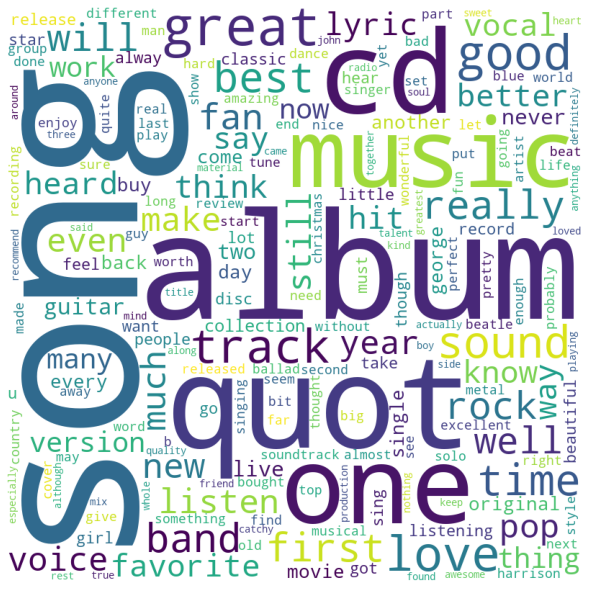

In [ ]:
# all positive genre + review labels
comment_words = ''
stopwords = set(STOPWORDS)
 
for val in pos_genre_df['label'].fillna(""):
    tokens = re.split(' |,', val)
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                collocations = False,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

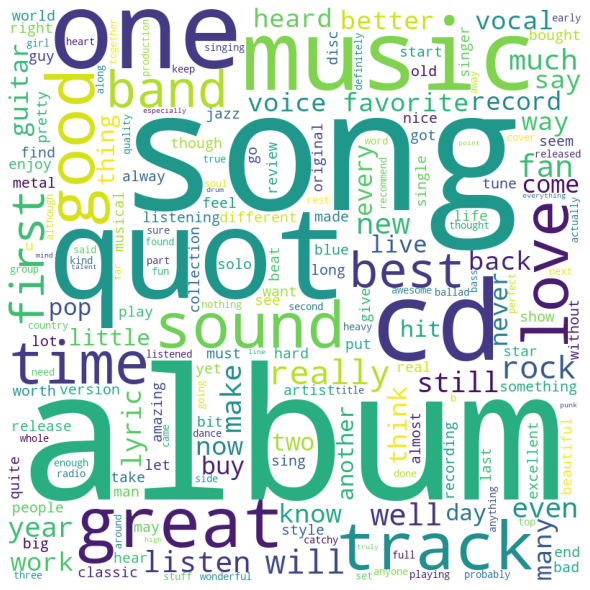

In [ ]:
# all negative genre + review labels
comment_words = ''
stopwords = set(STOPWORDS)
 
for val in neg_genre_df['label'].fillna(""):
    tokens = re.split(' |,', val)
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                collocations = False,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [ ]:
! pip install gdown
! gdown --folder https://drive.google.com/drive/folders/13UbMp_Q0PvnPsVNs7Aw4RWeiwT5cRatl?usp=sharing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
